# Yuma Takeichi June 23rd, 2025
### Analysis of the data from Juan_analysis
### Purpose: analyze the data we get from Juan_analysis

In [1]:
import pynbody as pb
import numpy as np
import pandas as pd
import glob
import os
import h5py
import tables
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
import os
from natsort import natsorted
import importlib.util
import sys
from pathlib import Path

In [2]:
file_path = '/home/takeichi/MAP/Juan_startrace/methods/src/jstreams/star_trace.py'
module_name = 'star_trace'

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [3]:
simname = 'h329'
res = '100'  # The Near Mint runs
#res = 'Mint'  # The MintPermissionError: file ``/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/h329.cosmo50PLK.3072gst5HbwK1BH.4096.trace_back.hdf5`` exists but it can not be read
simpath = '/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/'
basename = 'h329.cosmo50PLK.3072gst5HbwK1BH'
ss_dir = 'snapshots_200crit_h329/'
sim_base = simpath + ss_dir
ss_z0 = sim_base + basename + '.004096'

# Where to save the resulting data
data_folder = '/home/takeichi/MAP/Datafiles/stellarhalo_trace6'

### Setup before analysis
### Purpose: see the motion of the main halo's COM

In [4]:
datapath_halo1='/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/'
# define a function to give the halo data at a certain snapshot
def com_main_halo(snapshot):
    try:
        snapshot_num = int(snapshot)
        halodata=pb.load(f"{datapath_halo1}h329.cosmo50PLK.3072gst5HbwK1BH.{snapshot_num:06d}")
    except Exception as e:
        print(f"file cannot be loaded, {e}")
    halodata.physical_units()
    h=halodata.halos()
    a=pb.analysis.halo.center(h[1], return_cen=True)
    x=a[0]
    y=a[1]
    z=a[2]
    return x,y,z

In [18]:
pb.config['halo-class-priority'] = ['HaloNumberCatalogue', 'AHFCatalogue',
  'AmigaGrpCatalogue',
  'VelociraptorCatalogue',
  'SubFindHDFHaloCatalogue',
  'RockstarCatalogue', 
  'SubfindCatalogue',
  'NewAdaptaHOPCatalogue',
  'NewAdaptaHOPCatalogueFullyLongInts',
  'AdaptaHOPCatalogue',
  'HOPCatalogue',
  'Gadget4SubfindHDFCatalogue',
  'ArepoSubfindHDFCatalogue',
  'TNGSubfindHDFCatalogue']

In [19]:
snapshot_num=4096
halodata=pb.load(f"{datapath_halo1}h329.cosmo50PLK.3072gst5HbwK1BH.{snapshot_num:06d}")

In [21]:
halodata
h = halodata.halos(halo_numbers='v1')


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


In [22]:
h[1].properties

{'omegaM0': 0.3086,
 'omegaL0': 0.6914,
 'h': 0.6776942783267969,
 'boxsize': Unit("5.00e+04 kpc a"),
 'a': 0.9999999999639907,
 'time': Unit("1.41e+01 s kpc km**-1"),
 'halo_number': 1,
 'ID': np.int64(8690197310405638417),
 'hostHalo': np.int64(0),
 'numSubStruct': np.int64(522),
 'Mvir': np.float64(480810000000.0),
 'npart': np.int64(32638998),
 'Xc': np.float64(18214.69235333),
 'Yc': np.float64(13932.68669091),
 'Zc': np.float64(17944.07359824),
 'VXc': np.float64(33.43),
 'VYc': np.float64(-170.59),
 'VZc': np.float64(59.46),
 'Rvir': np.float64(127.4),
 'Rmax': np.float64(7.85),
 'r2': np.float64(0.01669),
 'mbp_offset': np.float64(0.1177),
 'com_offset': np.float64(2.67921),
 'Vmax': np.float64(246.0),
 'v_esc': np.float64(180.188403),
 'sigV': np.float64(229.67),
 'lambda': np.float64(0.016234),
 'lambdaE': np.float64(0.028052),
 'Lx': np.float64(-0.07828),
 'Ly': np.float64(-0.3033),
 'Lz': np.float64(0.9497),
 'b': np.float64(0.950775),
 'c': np.float64(0.901733),
 'Eax': np

In [26]:

# 'Xc'の単位は、元のシミュレーションの'x'の単位と同じ
position_units = h.base['x'].units
# 'Rvir'も同様に位置の単位
print(f"Xc の値: {h[1].properties['Xc']}")
print(f"Xc の単位: {position_units}")
radius_units = h.base['pos'].units # 'pos'でも可
print(f"Rvir の値: {h[1].properties['Rvir']}")
print(f"Rvir の単位: {radius_units}")

Xc の値: 18214.69235333
Xc の単位: 5.00e+04 kpc a
Rvir の値: 127.4
Rvir の単位: 5.00e+04 kpc a


In [12]:
keys = list(h)
print(keys[0:10])

[<Halo "/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/h329.cosmo50PLK.3072gst5HbwK1BH.004096:halo_0" len=21563559>, <Halo "/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/h329.cosmo50PLK.3072gst5HbwK1BH.004096:halo_1" len=32288266>, <Halo "/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/h329.cosmo50PLK.3072gst5HbwK1BH.004096:halo_7" len=129015>, <Halo "/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/h329.cosmo50PLK.3072gst5HbwK1BH.004096:halo_14" len=71107>, <Halo "/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/h329.cosmo50PLK.3072gst5HbwK1BH.004096:halo_29" len=33381>, <Halo "/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200crit_h329/h329.cosmo50PLK.3072gst5HbwK1BH.004096:halo_30" len=31869>, <Halo "/data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5H

### Running Star_trace.py

In [4]:
halo_trace_files = sorted(glob.glob(simpath+ss_dir+basename+'.????.trace_back.hdf5'))

In [5]:
trace = pd.read_hdf(halo_trace_files[-1], index_col=0)
halos_grpNow = np.array(trace.index) # Array of the final halo grps

In [6]:
trace

,004032,003936,003840,003744,003648,003606,003552,003456,003360,003264,...,000347,000288,000275,000225,000192,000188,000139,000107,000096,000071
004096,,,,,,,,,,,,,,,,,,,,,
115,116,116,116,121,119,120,121,118,113,112,...,64,-1,-1,-1,-1,-1,-1,-1,-1,-1
117,119,119,122,123,122,124,125,126,128,128,...,23,20,19,17,13,14,11,-1,-1,-1
1308,1278,1113,913,987,882,883,874,850,829,792,...,58,61,67,91,67,63,-1,-1,-1,-1
154,154,151,151,151,154,151,149,150,151,148,...,61,58,57,62,54,50,41,-1,-1,-1
37,33,28,23,22,25,24,25,25,25,27,...,84,90,78,69,50,48,62,-1,-1,-1
631,593,391,377,375,372,368,365,366,353,342,...,99,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,7,6,6,6,5,5,5,5,5,5,...,21,18,21,21,19,19,29,-1,-1,-1
859,744,682,665,659,637,630,620,602,573,467,...,69,59,63,61,52,52,47,-1,-1,-1


In [6]:
halos_grpNow = [115,117,1308,154,37,631,7,859]

In [4]:
module.main(halos_grpNow=halos_grpNow, sim_base=sim_base, 
            trace_file=halo_trace_files[-1].split('/')[-1], 
            data_folder=data_folder)

In [10]:
#check the content of the h5 file we get by the main function
file = f"{data_folder}/star_trace/{halos_grpNow[0]:05d}/particle_data.h5"
print(f"{snapshot_list[0]}")
with h5py.File(file, "r") as f:
    f.visit(print)
    x = f[f"{halos_grpNow[0]:06d}/x"][:]
    y = f[f"{halo_id}/y"][:]
    print(len(x))
    

### Analysis of the data
・Make a mp4 file of the star distribution(2D)

・Make a csv file

・plot the radial distribution histogram

・plot the movement of the COM of each halo

・relationship between the total steller mass and r50

・relationship between the age and r50

・relationship between the age and total steller mass

In [6]:

#Make a mp4 file of the star distribution(2D)
halos_grpNow = [115,117,1308,154,37,631,7,859]
data_folder="/home/takeitchi/MAP/Datafiles/stellarhalo_trace6"
output_img_root = f"{data_folder}/plots_by_halos"
os.makedirs(output_img_root, exist_ok=True)
star_file=f"{data_folder}/star_trace/{halos_grpNow[0]:05d}/particle_data.h5"
snapshot_list=sorted([str(k) for k in h5py.File(star_file, 'r').keys()],key=int)

for idx, halo_id in enumerate(halos_grpNow):
    halo_output_dir = os.path.join(output_img_root, f"{halo_id:05d}")
    os.makedirs(halo_output_dir, exist_ok=True)
    file = f"{data_folder}/star_trace/{halo_id:05d}/particle_data.h5"
    for snap in snapshot_list:
        try:
            with h5py.File(file, "r") as f:
                x = f[f"{snap}/x"][:]
                y = f[f"{snap}/y"][:]
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_title(f"Halo {halo_id} - Snapshot {snap}")
            ax.set_xlabel("x [kpc]")
            ax.set_ylabel("y [kpc]")
            ax.scatter(x, y, s=20, color=cmap(idx % 10))
            ax.grid(True)
            save_path = os.path.join(halo_output_dir, f"{snap}.png")
            plt.savefig(save_path)
            plt.close(fig)
        except Exception as e:
            print(f"Failed to load halo {halo_id} at snapshot {snap}: {e}")
t
import imageio
from natsort import natsorted
output_video_dir = os.path.join(data_folder, "Videos_by_halo")
os.makedirs(output_video_dir, exist_ok=True)
for halo_id in halos_grpNow:
    halo_image_dir = os.path.join(output_img_root, f"{halo_id:05d}")
    image_files = [f for f in os.listdir(halo_image_dir) if f.endswith(".png")]
    image_files = natsorted(image_files)
    output_path = os.path.join(output_video_dir, f"halo_{halo_id:05d}.mp4")
    with imageio.get_writer(output_path, fps=3) as writer:
        for fname in image_files:
            image_path = os.path.join(halo_image_dir, fname)
            image = imageio.imread(image_path)
            writer.append_data(image)
    print(f"Video saved: {output_path}")

Failed to load halo 859 at snapshot 000864: 'Unable to synchronously open object (component not found)'


/tmp/ipykernel_69890/3712685814.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x71d3d40] Stream #0: not enough frames to estimate rate; consider increasing probesize
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macr

Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_00115.mp4


[rawvideo @ 0x842bd40] Stream #0: not enough frames to estimate rate; consider increasing probesize
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_00117.mp4


[rawvideo @ 0x8521d40] Stream #0: not enough frames to estimate rate; consider increasing probesize
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_01308.mp4


[rawvideo @ 0x7f58d40] Stream #0: not enough frames to estimate rate; consider increasing probesize
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_00154.mp4


[rawvideo @ 0x6fddd40] Stream #0: not enough frames to estimate rate; consider increasing probesize
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_00037.mp4


[rawvideo @ 0x7254d40] Stream #0: not enough frames to estimate rate; consider increasing probesize
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_00631.mp4


[rawvideo @ 0x73ced40] Stream #0: not enough frames to estimate rate; consider increasing probesize
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_00007.mp4


[rawvideo @ 0x7c18d40] Stream #0: not enough frames to estimate rate; consider increasing probesize


Video saved: /home/takeichi/MAP/Datafiles/stellarhalo_trace6/Videos_by_halo/halo_00859.mp4


In [5]:
#make a csv file
from scipy.spatial.distance import cdist
import pynbody as pb
import numpy as np
import pandas as pd
import glob
import os
import h5py
import tables
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
import os
from natsort import natsorted
import importlib.util
import sys
from pathlib import Path
halos_grpNow = [115,117,1308,154,37,631,7,859]
data_folder="/home/takeichi/MAP/Datafiles/stellarhalo_trace6"
results_record=[]
Grav_const=4.302e-6
epsilon=1.0e-3
star_file=f"{data_folder}/star_trace/{halos_grpNow[0]:05d}/particle_data.h5"
snapshot_list=sorted([str(k) for k in h5py.File(star_file, 'r').keys()],key=int)
for snap in snapshot_list:
    xmain, ymain, zmain = com_main_halo(snap)
    for idx, halo_id in enumerate(halos_grpNow):
        try:
            file = f"{data_folder}/star_trace/{halos_grpNow[idx]:05d}/particle_data.h5"
            with h5py.File(file, "r") as f:
                group = f[snap]
                x = group['x'][:]
                y = group['y'][:]
                z = group['z'][:]
                #vx = group['vx'][:]
                #vy = group['vy'][:]
                #vz = group['vz'][:]
                mass = group['mass'][:]
                tform = group['tform'][:]
                #feh = group['feh'][:]
                if len(x)>0:
                    x_com = np.sum(x*mass)/np.sum(mass)-xmain
                    y_com = np.sum(y*mass)/np.sum(mass)-ymain
                    z_com = np.sum(z*mass)/np.sum(mass)-zmain
                else:
                    x_com = None
                    y_com = None
                    z_com = None
                    print(f"no particles of {halo_id} in {snap} ")
                #rx=x-x_com
                #ry=y-y_com
                #rz=z-z_com
                #rx=[a-x_com for a in x]
                #ry=[a-y_com for a in y]
                #rz=[a-z_com for a in z]
                #r=np.sqrt(rx**2+ry**2+rz**2) # distance from the COM
                #R=np.sqrt(x**2+y**2+z**2)
                #V=np.sqrt(vx**2+vy**2+vz**2)
                #kinetic=(V**2)/2
                #pos = np.vstack([x,y,z]).T
                #distance=cdist(pos,pos)
                #distance+=epsilon
                #np.fill_diagonal(distance,np.inf)
                #potential=-Grav_const*np.sum(mass/distance, axis=1)
                #total_energy=kinetic+potential
                #bounded_indices=np.where(total_energy<0)
                #num_bounded_stars=len(bounded_indices)
                #f_bound=num_bounded_stars/len(x)
                #Rmean= np.mean(R)

                #sorted_ind=np.argsort(R)
                #cum_mass=np.cumsum(mass[sorted_ind])
                #mass_total=cum_mass[-1]
                #halfmass=mass_total/2
                #R_50=R[sorted_ind][np.searchsorted(cum_mass, halfmass)]

                #sorted_ind2=np.argsort(r)
                #cum_mass2=np.cumsum(mass[sorted_ind2])
                #mass_total2=cum_mass2[-1]
                #halfmass2=mass_total2/2
                #r_50=r[sorted_ind2][np.searchsorted(cum_mass2, halfmass2)] #r_50 is the distance that inside of the sphere with that radius, there is 50% of mass
                
                #tform_median=np.nanmedian(tform)
                #feh_median=np.nanmedian(feh)

                results_record.append({
                    "num_particle": len(x),
                    "snapshot": int(snap),
                    "halo_id": halo_id,
                    "x": x,
                    "y": y,
                    "z": z,
                    #"vx": vx,
                    #"vy": vy,
                    #"vz": vz,
                    "x_com": x_com,
                    "y_com": y_com,
                    "z_com": z_com,
                    "mass": mass.tolist(),
                    "tform": tform,
                    #"tform_median": tform_median,
                    #"feh_median": feh_median,
                    #"feh": feh,
                    #"r": r.tolist(),
                    #"R": R,
                    #"Rmean": Rmean,
                    #"V": V,
                    #"mass_total": mass_total,
                    #"R_50": R_50,
                    #"f_bound": f_bound,
                    #"r_50": r_50,
                    "xmain": xmain,
                    "ymain": ymain,
                    "zmain": zmain,
                    
                })
        except Exception as e:
            print(f"Failed to load halo {halo_id} at snapshot {snap}: {e}")
            continue
    print(f"saved for {snap}")

df = pd.DataFrame(results_record)
df.sort_values(by=["halo_id","snapshot"], inplace=True)
df.to_csv(os.path.join(data_folder, "halo_star_properties_with_COM_ver5.csv"), index=False)

no particles of 115 in 000347 
no particles of 1308 in 000347 
saved for 000347
no particles of 115 in 000384 
no particles of 1308 in 000384 
saved for 000384
no particles of 115 in 000456 
no particles of 1308 in 000456 
saved for 000456
no particles of 1308 in 000480 
saved for 000480
saved for 000576
saved for 000637
saved for 000672
saved for 000768
saved for 000776
Failed to load halo 859 at snapshot 000864: "Unable to synchronously open object (object '000864' doesn't exist)"
saved for 000864
saved for 000960
saved for 000974
saved for 001056
saved for 001106
saved for 001152
saved for 001248
saved for 001269
saved for 001344
saved for 001440
saved for 001475
saved for 001536
saved for 001632
saved for 001728
saved for 001740
saved for 001824
saved for 001920
saved for 002016
saved for 002088
saved for 002112
saved for 002208
saved for 002304
saved for 002400
saved for 002496
saved for 002554
saved for 002592
saved for 002688
saved for 002784
saved for 002880
saved for 002976
sa

In [7]:
# plot the radial distribution histogram
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
halos_grpNow = [115,117,1308,154,37,631,7,859]
data_folder="/home/takeichi/MAP/Datafiles/stellarhalo_trace6"
csv_path=os.path.join(data_folder, "halo_star_properties_with_COM_ver4.csv")

try:
    df=pd.read_csv(csv_path)
    # change r into list in case it is not
    df['r'] = df['r'].apply(ast.literal_eval)
    df['mass'] = df['mass'].apply(ast.literal_eval)
except Exception as e:
    print(f"File loading error, {e}")
    
output_dir3=os.path.join(data_folder, "r_mass_plots")
os.makedirs(output_dir3, exist_ok=True)
width = 0.5


for halo_id in sorted(df["halo_id"].unique()):
    sub=df[df["halo_id"] == halo_id].copy()
    if sub.empty:
        print(f"No data is found for halo{halo_id}")
        continue
    # I want to get the maximum value of the r value for each halo
    r_halo = np.concatenate(sub['r'].values)
    if len(r_halo) == 0:
        print("No star particles found in halo {halo_id}")
        continue
    r_max=np.max(r_halo)*1.1
    if r_max < 5:
        r_max = 5

    bins=np.arange(0, r_max+width, width)
    bins_ctr=(bins[:-1]+bins[1:])/2
    for snapshot in sorted(sub["snapshot"].unique(), key=int):
        sub_snap=sub[sub["snapshot"] == snapshot]
        try:
            #print(sub_snap["r"].values[0])
            r_array=np.array(sub_snap["r"].values[0])
            r50=sub_snap["r_50"].iloc[0]
            mass_array=np.array(sub_snap["mass"].values[0])
            #r=sub_snap["r"].values[0]
            #print(r)
            total_mass=np.sum(mass_array)
        except Exception as e:
            print(f"failed to load r for halo {halo_id} in snapshot {snapshot}: {e}")
            continue
        fig, ax=plt.subplots(figsize=(10,7))
        #bins=np.arange(0, r_max+width, width)
        ax.hist(r_array, bins=bins, color="r")
        ax.axvline(x=r50, color="blue", linewidth=2, label=f"r50 = {r50}")
        ax.set_xlim(0,r_max)
        ax.set_xlabel(f"Distance from the COM of halo {halo_id} (kpc)")
        ax.set_ylabel("number of star particles")
        ax2=ax.twinx()
        if total_mass>0:
            mass_in_bin,_ =np.histogram(r_array, bins=bins, weights=mass_array)
            f_mass=mass_in_bin/total_mass*100
            ax2.plot(bins_ctr, f_mass, color="orange", marker='o', linestyle='-', label="Mass Fraction")
            ax2.set_ylabel("Mass Fraction")
            ax2.set_ylim(0,100)
            
        ax.set_title(f"r Distribution and Mass Fraction of halo {halo_id} in snapshot {snapshot}")
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        
        filename=f"r_mass_plots_{halo_id:05d}_snapshot_{snapshot:05d}"
        plt.savefig(os.path.join(output_dir3, filename))
        plt.close(fig)

In [8]:
# make the histogram to the gif file (seeing the change of it through time)
output_dir3=os.path.join(data_folder, "r_mass_plots")
output_dir=os.path.join(data_folder, "r_mass_plots_gif")
os.makedirs(output_dir, exist_ok=True)
for halo_id in df["halo_id"].unique():
    file=[f for f in os.listdir(output_dir3) if f"mass_plots_{halo_id:05d}" in f]
    file=natsorted(file)
    path=[os.path.join(output_dir3, f) for f in file]
    if not path:
        print(f"No files found for halo{halo_id}")
        continue
    gif_path=os.path.join(output_dir, f"r_mass_plots_halo_{halo_id}.gif")
    with imageio.get_writer(gif_path, mode="I", duration=0.5) as writer:
        for p in path:
            image = imageio.imread(p)
            writer.append_data(image)
    print(f"Saved gif for {halo_id}")

/tmp/ipykernel_58510/3113954550.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(p)


Saved gif for 7
Saved gif for 37
Saved gif for 115
Saved gif for 117
Saved gif for 154
Saved gif for 631
Saved gif for 859
Saved gif for 1308


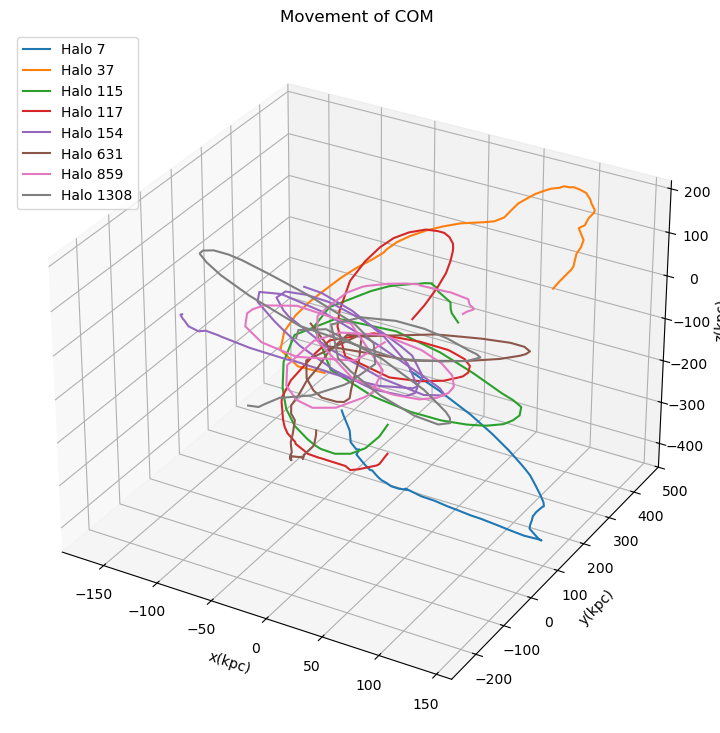

In [29]:
#show the movement of each halo's COM
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig= plt.figure(figsize=(12,9))
ax=fig.add_subplot(111, projection='3d')
for halo_id in df["halo_id"].unique():
    sub = df[df["halo_id"] == halo_id]
    ax.plot(sub["x_com"], sub["y_com"], sub["z_com"], label=f"Halo {halo_id}")
ax.set_xlabel("x(kpc)")
ax.set_ylabel("y(kpc)")
ax.set_zlabel("z(kpc)")
ax.set_title("Movement of COM")
ax.legend()
#plt.grid(True)
plt.savefig('Movement_COM.png')
plt.show()

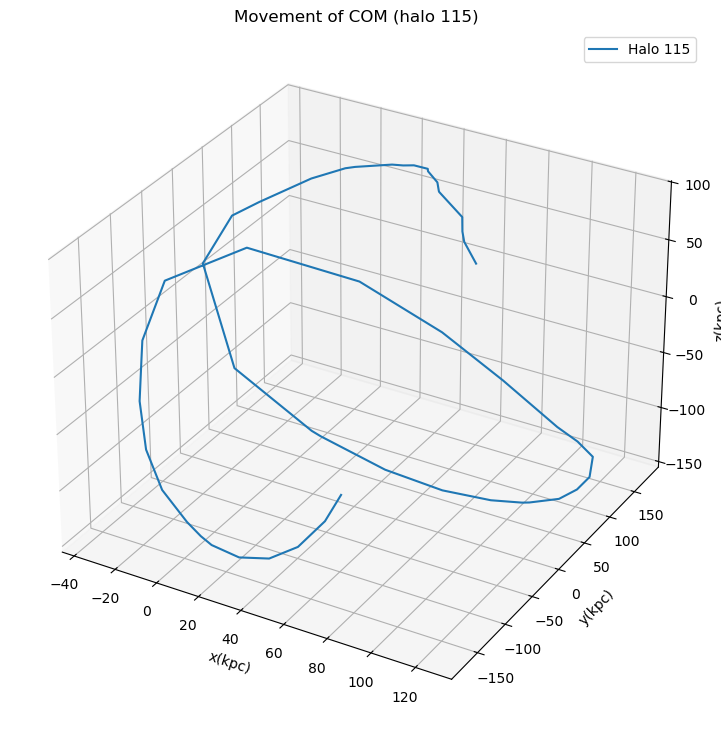

In [30]:
#show the movement of each halo's COM (halo115)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig= plt.figure(figsize=(12,9))
ax=fig.add_subplot(111, projection='3d')
for halo_id in df["halo_id"].unique():
    if halo_id==115:
        sub = df[df["halo_id"] == halo_id]
        ax.plot(sub["x_com"], sub["y_com"], sub["z_com"], label=f"Halo {halo_id}")
ax.set_xlabel("x(kpc)")
ax.set_ylabel("y(kpc)")
ax.set_zlabel("z(kpc)")
ax.set_title("Movement of COM (halo 115)")
ax.legend()
#plt.grid(True)
plt.savefig('Movement_COM_halo115.png')
plt.show()

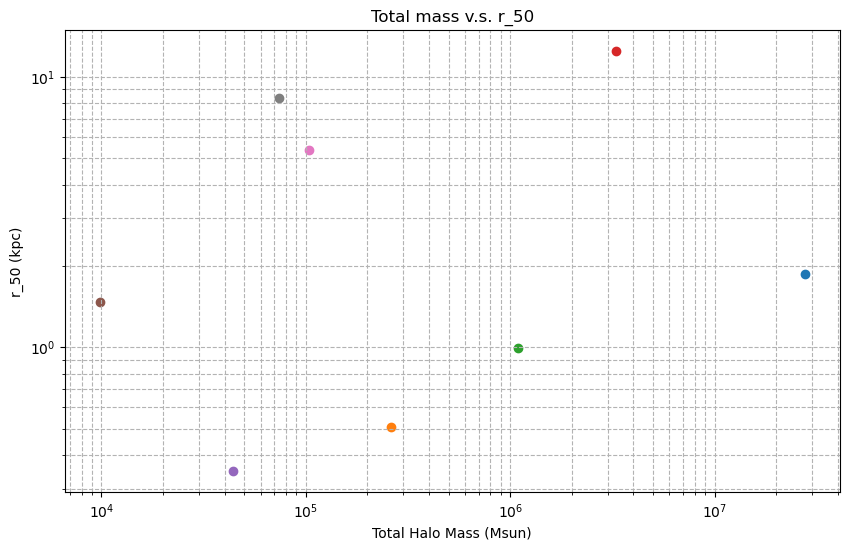

In [21]:
#・relationship between the total steller mass and r50

halos_grpNow = [115,117,1308,154,37,631,7,859]
data_folder="/home/takeichi/MAP/Datafiles/stellarhalo_trace6"
csv_path=os.path.join(data_folder, "halo_star_properties_with_COM_ver4.csv")

try:
    df=pd.read_csv(csv_path)
    # change r into list in case it is not
    df['r'] = df['r'].apply(ast.literal_eval)
    df['mass'] = df['mass'].apply(ast.literal_eval)
except Exception as e:
    print(f"File loading error, {e}")
plt.figure(figsize=(10, 6))
for halo_id in sorted(df["halo_id"].unique()):
    sub=df[df["halo_id"] == halo_id].copy()
    if sub.empty:
        print(f"No data is found for halo{halo_id}")
        continue
    for snapshot in sorted(sub["snapshot"].unique(), key=int):
        sub_snap=sub[sub["snapshot"] == snapshot]
        if snapshot==4096:
            try:
        #print(sub_snap["r"].values[0])
                r_array=np.array(sub_snap["r"].values[0])
                r_50=sub_snap["r_50"].iloc[0]
                mass_array=np.array(sub_snap["mass"].values[0])
            #r=sub_snap["r"].values[0]
            #print(r)
                total_mass=np.sum(mass_array)
                if total_mass!=0:
                    plt.scatter(total_mass, r_50)
            except Exception as e:
                print(f"failed to load r for halo {halo_id} in snapshot {snapshot}: {e}")
                continue
    
plt.xlabel('Total Halo Mass (Msun)')
plt.ylabel('r_50 (kpc)')
plt.xscale('log') 
plt.yscale('log') 
plt.grid(True, which="both", ls="--", c='0.7')
#plt.tight_layout()
plt.title("Total mass v.s. r_50")
plt.savefig("r50_Totalmass.png")
plt.show()

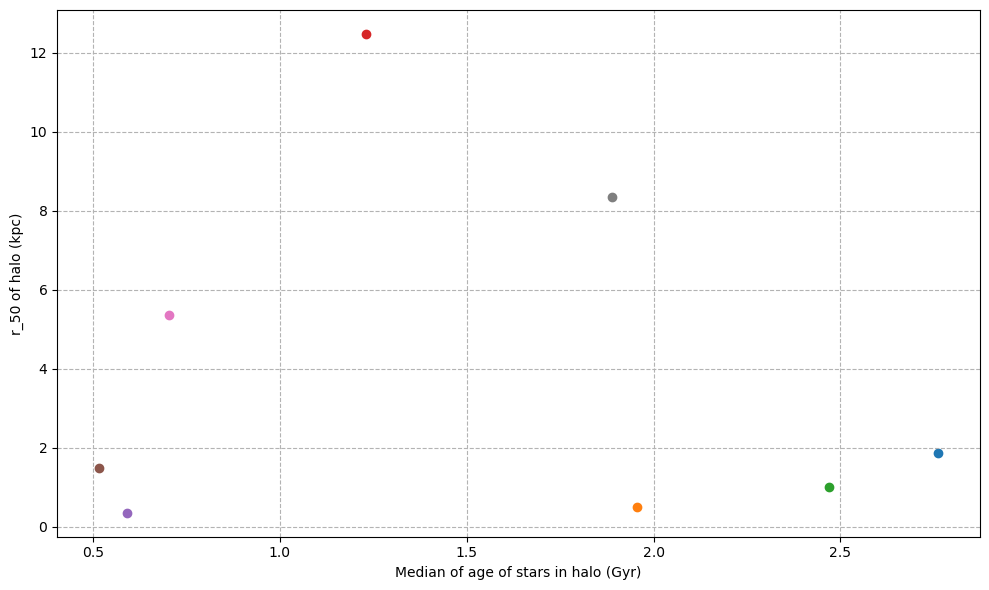

In [22]:
#relationship between the age and r50


halos_grpNow = [115,117,1308,154,37,631,7,859]
data_folder="/home/takeichi/MAP/Datafiles/stellarhalo_trace6"
csv_path=os.path.join(data_folder, "halo_star_properties_with_COM_ver4.csv")

try:
    df=pd.read_csv(csv_path)
    # change r into list in case it is not
    df['r'] = df['r'].apply(ast.literal_eval)
    df['mass'] = df['mass'].apply(ast.literal_eval)
except Exception as e:
    print(f"File loading error, {e}")
plt.figure(figsize=(10, 6))
for halo_id in sorted(df["halo_id"].unique()):
    sub=df[df["halo_id"] == halo_id].copy()
    if sub.empty:
        print(f"No data is found for halo{halo_id}")
        continue
    for snapshot in sorted(sub["snapshot"].unique(), key=int):
        sub_snap=sub[sub["snapshot"] == snapshot]
        if snapshot==4096:
            try:
        #print(sub_snap["r"].values[0])
                r_array=np.array(sub_snap["r"].values[0])
                r_50=sub_snap["r_50"].iloc[0]
                tform_median=sub_snap["tform_median"].iloc[0]
                mass_array=np.array(sub_snap["mass"].values[0])
            #r=sub_snap["r"].values[0]
            #print(r)
                total_mass=np.sum(mass_array)
                plt.scatter(tform_median, r_50)
            except Exception as e:
                print(f"failed to load r for halo {halo_id} in snapshot {snapshot}: {e}")
                continue
    
plt.xlabel('Median of age of stars in halo (Gyr)')
plt.ylabel('r_50 of halo (kpc)')
#plt.yscale('log') 
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()

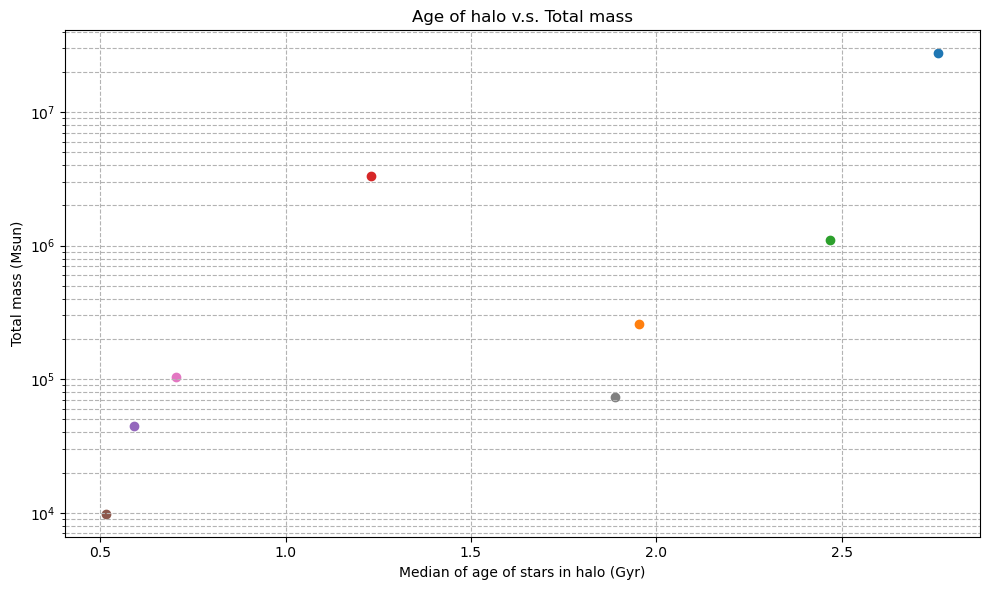

In [17]:
#relationship between the age and total steller mass
halos_grpNow = [115,117,1308,154,37,631,7,859]
data_folder="/home/takeichi/MAP/Datafiles/stellarhalo_trace6"
csv_path=os.path.join(data_folder, "halo_star_properties_with_COM_ver4.csv")

try:
    df=pd.read_csv(csv_path)
    # change r into list in case it is not
    df['r'] = df['r'].apply(ast.literal_eval)
    df['mass'] = df['mass'].apply(ast.literal_eval)
except Exception as e:
    print(f"File loading error, {e}")
plt.figure(figsize=(10, 6))
for halo_id in sorted(df["halo_id"].unique()):
    sub=df[df["halo_id"] == halo_id].copy()
    if sub.empty:
        print(f"No data is found for halo{halo_id}")
        continue
    for snapshot in sorted(sub["snapshot"].unique(), key=int):
        sub_snap=sub[sub["snapshot"] == snapshot]
        if snapshot==4096:
            try:
        #print(sub_snap["r"].values[0])
                r_array=np.array(sub_snap["r"].values[0])
                r_50=sub_snap["r_50"].iloc[0]
                tform_median=sub_snap["tform_median"].iloc[0]
                mass_array=np.array(sub_snap["mass"].values[0])
            #r=sub_snap["r"].values[0]
            #print(r)
                total_mass=np.sum(mass_array)
                plt.scatter(tform_median, total_mass)
            except Exception as e:
                print(f"failed to load r for halo {halo_id} in snapshot {snapshot}: {e}")
                continue
    
plt.xlabel('Median of age of stars in halo (Gyr)')
plt.yscale('log') 
plt.ylabel('Total mass (Msun)')
plt.grid(True, which="both", ls="--", c='0.7')
plt.title("Age of halo v.s. Total mass")
plt.tight_layout()
plt.savefig("Age_Totalmass.png")
plt.show()